# Exploring WT expression threshold cutoff for nipBL dataset

***Purpose:*** To get more granularity on patterns of expression by referencing against wild-type expression. 

Aiming to answer questions such as: 
* does adding a threshold cut-off for WT expression make the observed patterns more apparent? 
* Do down-regulated genes seem more similar to non-significant genes that have high levels of expression?

Plots:
* Histogram of average counts, using different tables
* Using threshold cut-off to see distribution of [num enhancers/TAD] vs [num. genes/TAD]

In [2]:
import sys
 
# setting path
sys.path.append('../../transcription_data_analysis')

import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [3]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Load data and project files

Using dataloader function to add feature annotations to gene set: TSS locations
Merging average normalized feature counts and average vst-normalized feature counts into results table

In [4]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/filter_gene_functions.py'>

In [5]:
project_folder = ('/project/fudenber_735/collaborations/' +
                   'karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/'
                  )

# Getting average counts for all three counts datasets
day1_res_df = flt.load_tss_df(
                counts_tables={'raw_counts_name' : project_folder+'20220816_featureCounts.csv',
                               'counts' : project_folder+'20220816_featureCounts.csv',
                                'norm_counts' : project_folder+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv',
                                'vst_counts' : project_folder+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv',
                              },
                counts_usage={'raw_counts_name' : 'append_name',
                              'counts' : 'wt_avg',
                              'norm_counts' : 'wt_avg',
                              'vst_counts' : 'wt_avg'
                             },
                cutoff=None)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


# Distribution of WT expression levels

### Average counts -- default normalization

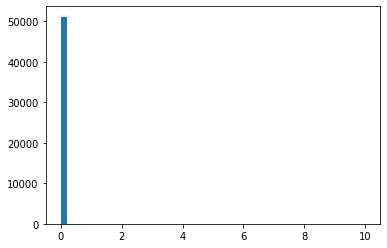

In [6]:
plt.hist(day1_res_df['avg_norm_counts'].values, range=(0, 10), bins=50)
plt.show()

### Average Counts -- not normalized

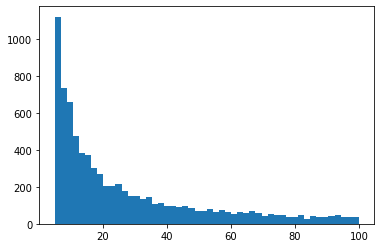

In [7]:
plt.hist(day1_res_df['avg_counts'].values, range=(5, 100), bins=50)
plt.show()

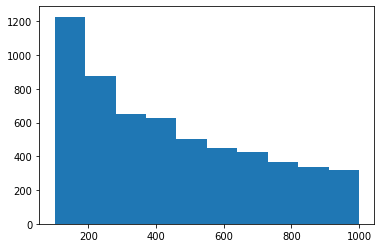

In [8]:
plt.hist(day1_res_df['avg_counts'].values, range=(100, 1000))
plt.show()

### average vst-normalized counts

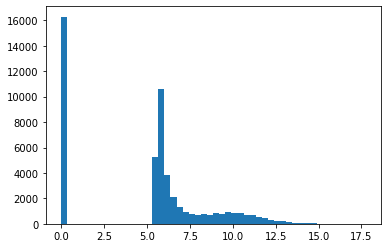

In [9]:
plt.hist(day1_res_df['avg_vst_counts'].values, bins=50)
plt.show()

### distribution of vst-normalized counts in nonsignificant genes

In [10]:
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

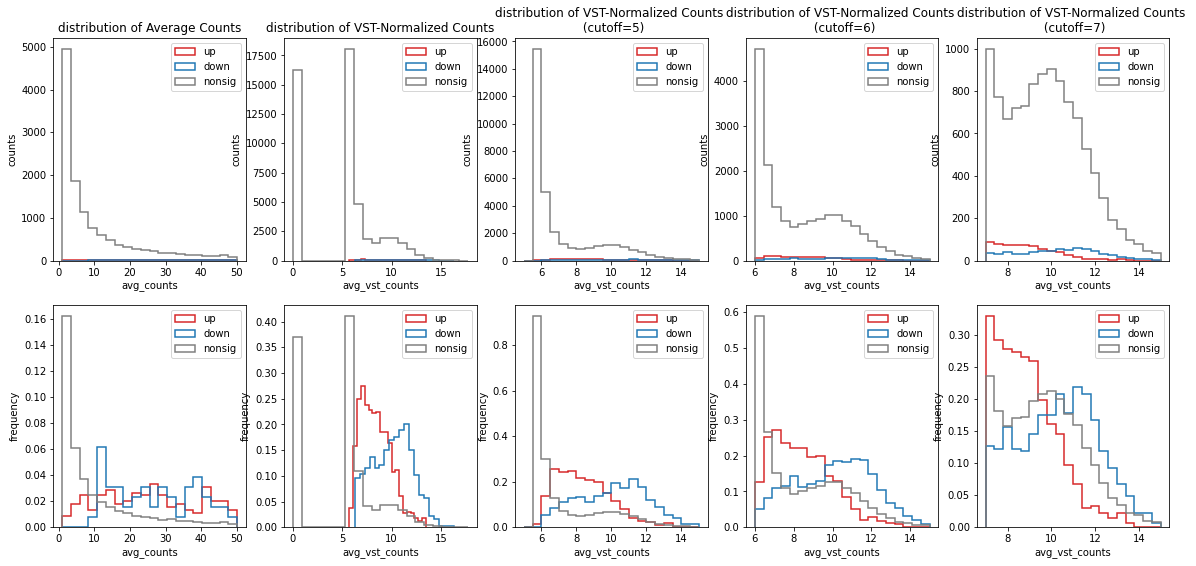

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(20, 9))

plot_vars = [{'title': 'distribution of Average Counts',
              'col' : 'avg_counts',
              'range' : (1, 50),
              'ax1' : 0},
             {'title': 'distribution of VST-Normalized Counts',
              'col' : 'avg_vst_counts',
              'range' : None,
              'ax1' : 1},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=5)',
              'col' : 'avg_vst_counts',
              'range' : (5, 15),
              'ax1' : 2},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=6)',
              'col' : 'avg_vst_counts',
              'range' : (6, 15),
              'ax1' : 3},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=7)',
              'col' : 'avg_vst_counts',
              'range' : (7, 15),
              'ax1' : 4}]

for params in plot_vars:
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            bins=20,
                            plot_title=params['title'],
                            val_range=params['range'],
                            ax=axs[0, params['ax1']])
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            density=True,
                            bins=20,
                            val_range=params['range'],
                            ax=axs[1, params['ax1']])

### Observations:

It looks like the vst-normalized counts may have already enforced a threshold cut-off when exporting the results table from DESeq2. 

Generally, will threshold this dataset at vst_counts=6.

# Plot number of enhancers and DE genes within each TAD

How many dysregulated genes contain a distal enhancer in the same TAD?

* Investigating gene dysregulation relative to enhancers + HiC
* Comparing effect of applying threshold (cutoff = 6) before splitting datasets based on WT expression counts

In [12]:
# load Hi-C data and features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

### label distance to closest enhancer for each gene

In [13]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

In [14]:
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

In [15]:
print('how many genes did not receive an enhancer label --> dropped')
print((day1_res_df['chen_s1_distance'].isna() |
       day1_res_df['wythe_super_distance'].isna()
      ).sum())
day1_res_df.dropna(subset=
                   ['chen_s1_distance', 
                    'wythe_super_distance'], 
                   inplace=True
                  )

how many genes did not receive an enhancer label --> dropped
0


In [16]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# label quantiles using full range of vst-normalized counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df)
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='down')

category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

category_colormap_DE = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5'
                        }

/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:269: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:269: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0

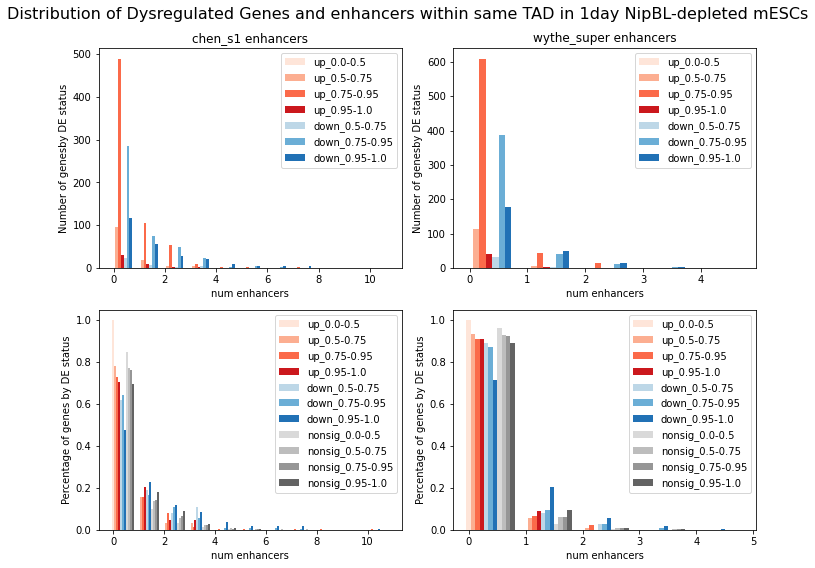

In [17]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_DE,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

### Applying threshold = 6 before setting quantiles

In [18]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      25557
nonsig_0.5-0.75     12614
nonsig_0.75-0.95     9110
nonsig_0.95-1.0      2265
up_0.75-0.95          669
down_0.75-0.95        443
down_0.95-1.0         247
up_0.5-0.75           123
up_0.95-1.0            44
down_0.5-0.75          37
up_0.0-0.5              1
Name: DE_status, dtype: int64

In [19]:
# set counts threshold to 6.0
cutoff = 6.0

# printing genes that fall below this cutoff -- are now excluded from dataset
below = (day1_res_df['avg_vst_counts'] <= cutoff)
day1_res_df[below]['DE_status'].value_counts()

nonsig    31755
up            6
Name: DE_status, dtype: int64

In [20]:
# set counts threshold to 6.0
cut = (day1_res_df['avg_vst_counts'] > cutoff)
quantiled_df = day1_res_df[cut].copy()

quantiled_df = flt.label_quantiles(quantiled_df)
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='down')

In [21]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      9180
nonsig_0.5-0.75     4281
nonsig_0.75-0.95    3476
nonsig_0.95-1.0      854
up_0.0-0.5           363
up_0.5-0.75          342
down_0.75-0.95       283
down_0.5-0.75        214
down_0.0-0.5         132
up_0.75-0.95         110
down_0.95-1.0         98
up_0.95-1.0           16
Name: DE_status, dtype: int64

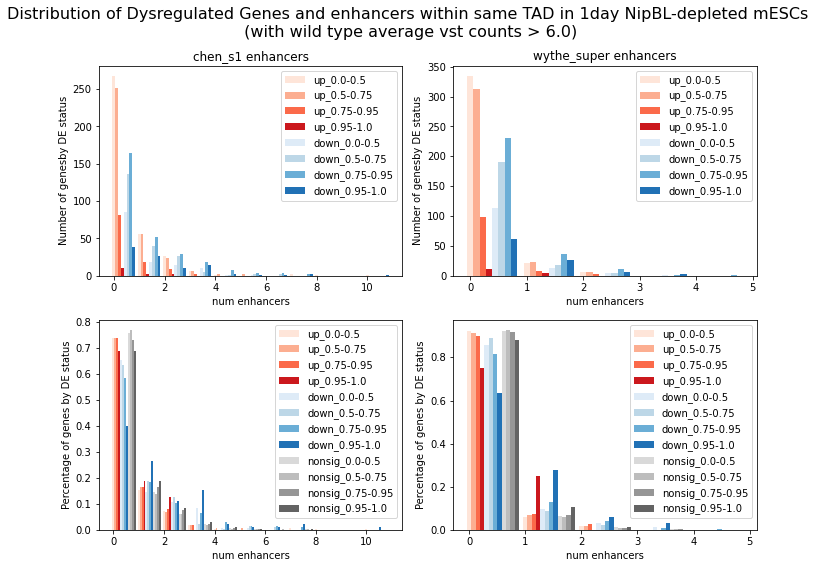

In [22]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'
             '\n (with wild type average vst counts > 6.0)'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_DE,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

# Observations

* Applying the threshold made both up/down DE genes follow more pronounced patterns in their upper-quartile
    * This appears to indicate that genes with higher wildtype expression were more likely to be impacted when an enhancer was located within their same TAD compared to if no enhancers
    * There are more down-regulated genes in TADs with higher number of enhancers

In [23]:
# Get the cutoffs
print(quantiled_df[quantiled_df['DE_status'] == 'nonsig_0.0-0.5']['avg_vst_counts'].max())
print(quantiled_df[quantiled_df['DE_status'] == 'nonsig_0.5-0.75']['avg_vst_counts'].max())

7.952766591140711
10.118402713192458


In [24]:
print(quantiled_df[quantiled_df['DE_status'] == 'down_0.0-0.5']['avg_vst_counts'].max())

7.950188339345787


In [25]:
# ignoring user warning can be added in cases where categories are null (e.g. without threshold)
## --> they are not plotted
warnings.simplefilter(action='ignore', category=UserWarning)